In [ ]:
# %load ../start.py
# Load useful extensions

# Activate the autoreload extension for easy reloading of external packages
%reload_ext autoreload
%autoreload 2

# Set up cashdir
from ipycache import CacheMagics
CacheMagics.cachedir = '../cachedir'

# Trun on the water mark
%reload_ext watermark
%watermark -u -d -v

# Load ipycache extension
%reload_ext ipycache
from ipycache import CacheMagics
CacheMagics.cachedir = '../cachedir'

# Add project library to path
import sys
sys.path.insert(0, '../../lib/python')

# The usual suspects
import os
import numpy as np
import pandas as pd

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_context('poster')

# Turn off scientific notation
np.set_printoptions(precision=5, supress=True)


In [3]:
# Get a list of all files
flist = []
for root, dirs, files in os.walk('../../output/prealignment/raw'):
    for file in files:
        flist.append(os.path.join(root, file))

In [26]:
# Parse logs
bamstat = parse_files(flist[:100], '../../output/prealignment/raw/{experiment}/{sample}/{sample}.bam_stat.txt', parse_bamStat)
dupradar = parse_files(flist[:100], '../../output/prealignment/raw/{experiment}/{sample}/{sample}.dupradar.tsv', parse_dupradar)
gbc = parse_files(flist[:100], '../../output/prealignment/raw/{experiment}/{sample}/{sample}.geneBodyCoverage.txt', parse_geneBodyCoverage)
infer = parse_files(flist[:100], '../../output/prealignment/raw/{experiment}/{sample}/{sample}.infer_experiment.txt', parse_inferExperiment)
tin = parse_files(flist[:100], '../../output/prealignment/raw/{experiment}/{sample}/{sample}.tin.txt', parse_tin)
featureCounts = parse_files(flist[:100], '../../output/prealignment/raw/{experiment}/{sample}/{sample}_1.fq.bam.counts', parse_featureCounts_counts)
featureCounts_summary = parse_files(flist[:100], '../../output/prealignment/raw/{experiment}/{sample}/{sample}_1.fq.bam.counts.summary', parse_featureCounts_summary)
picard1 = parse_files(flist[:100], '../../output/prealignment/raw/{experiment}/{sample}/{sample}_FIRST_READ_TRANSCRIPTION_STRAND.fq.bam.picard.collectrnaseqmetrics', parse_picardCollect_summary)
picard2 = parse_files(flist[:100], '../../output/prealignment/raw/{experiment}/{sample}/{sample}_FIRST_READ_TRANSCRIPTION_STRAND.fq.bam.picard.collectrnaseqmetrics', parse_picardCollect_hist)
bamtools_stats = parse_files(flist[:100], '../../output/prealignment/raw/{experiment}/{sample}/{sample}.fq.bam.bamtools.stats', parse_bamtools_stats)
picard_markdups = parse_files(flist[:100], '../../output/prealignment/raw/{experiment}/{sample}/{sample}.fq.bam.picard.markduplicatesmetrics', parse_picard_markduplicate_metrics)
samtools_idx = parse_files(flist[:100], '../../output/prealignment/raw/{experiment}/{sample}/{sample}.fq.bam.samtools.idxstats', parse_samtools_idxstats)
samtools_stats = parse_files(flist[:100], '../../output/prealignment/raw/{experiment}/{sample}/{sample}.fq.bam.samtools.stats', parse_samtools_stats)
libsize = parse_files(flist[:100], '../../output/prealignment/raw/{experiment}/{sample}/{sample}_1.clean.fastq.gz.libsize', parse_libsize)
atropos = parse_files(flist[:100], '../../output/prealignment/raw/{experiment}/{sample}/{sample}_1.trim.clean.fastq.gz.log', parse_atropos)

#fastqc = '../../output/prealignment/raw/DRX000999/DRR001445/DRR001445_fastqc.zip'

# Unique Samples

In [4]:
md5 = parse_files(flist, '../../output/prealignment/raw/{experiment}/{sample}/{sample}.md5', parse_md5)
joined = md5.sort_values(by='md5').reset_index().groupby('md5').agg(lambda x: '|'.join(x))
joined[joined['sample'].str.contains('\|')]

,sample
md5,


# Trimming

In [45]:
# Import atropos logs and munge
atropos = parse_files(flist, '../../output/prealignment/raw/{experiment}/{sample}/{sample}_1.trim.clean.fastq.gz.log', parse_atropos)

# Fix header
atropos.columns = header = ['Read 1', 'Read 2', 'Read 1 with adapter', 'Read 2 with adapter', 'Number Adapter illumina trimmed',
                            'Number Adapter polyA trimmed', 'Number Adapter polyT trimmed', 'Number First read: Adapter illumina trimmed',
                            'Number First read: Adapter polyA trimmed', 'Number First read: Adapter polyT trimmed', 'Number Second read: Adapter illumina trimmed',
                            'Number Second read: Adapter polyA trimmed', 'Number Second read: Adapter polyT trimmed', 'Pairs written (passing filters)', 'Quality-trimmed',
                            'Reads with adapters', 'Reads written (passing filters)', 'Total basepairs processed', 'Total read pairs processed',
                            'Total reads processed', 'Total written (filtered)']

# split into pe and se
pe = atropos[~atropos['Read 1'].isnull()].copy()
pe.dropna(axis=1, how='all', inplace=True)   # drop columns that are completely missing (i.e. SE)
pe.fillna(0, inplace=True)       # fill in any odd missing value

se = atropos[atropos['Read 1'].isnull()].copy()
se.dropna(axis=1, how='all', inplace=True)
se.fillna(0, inplace=True)

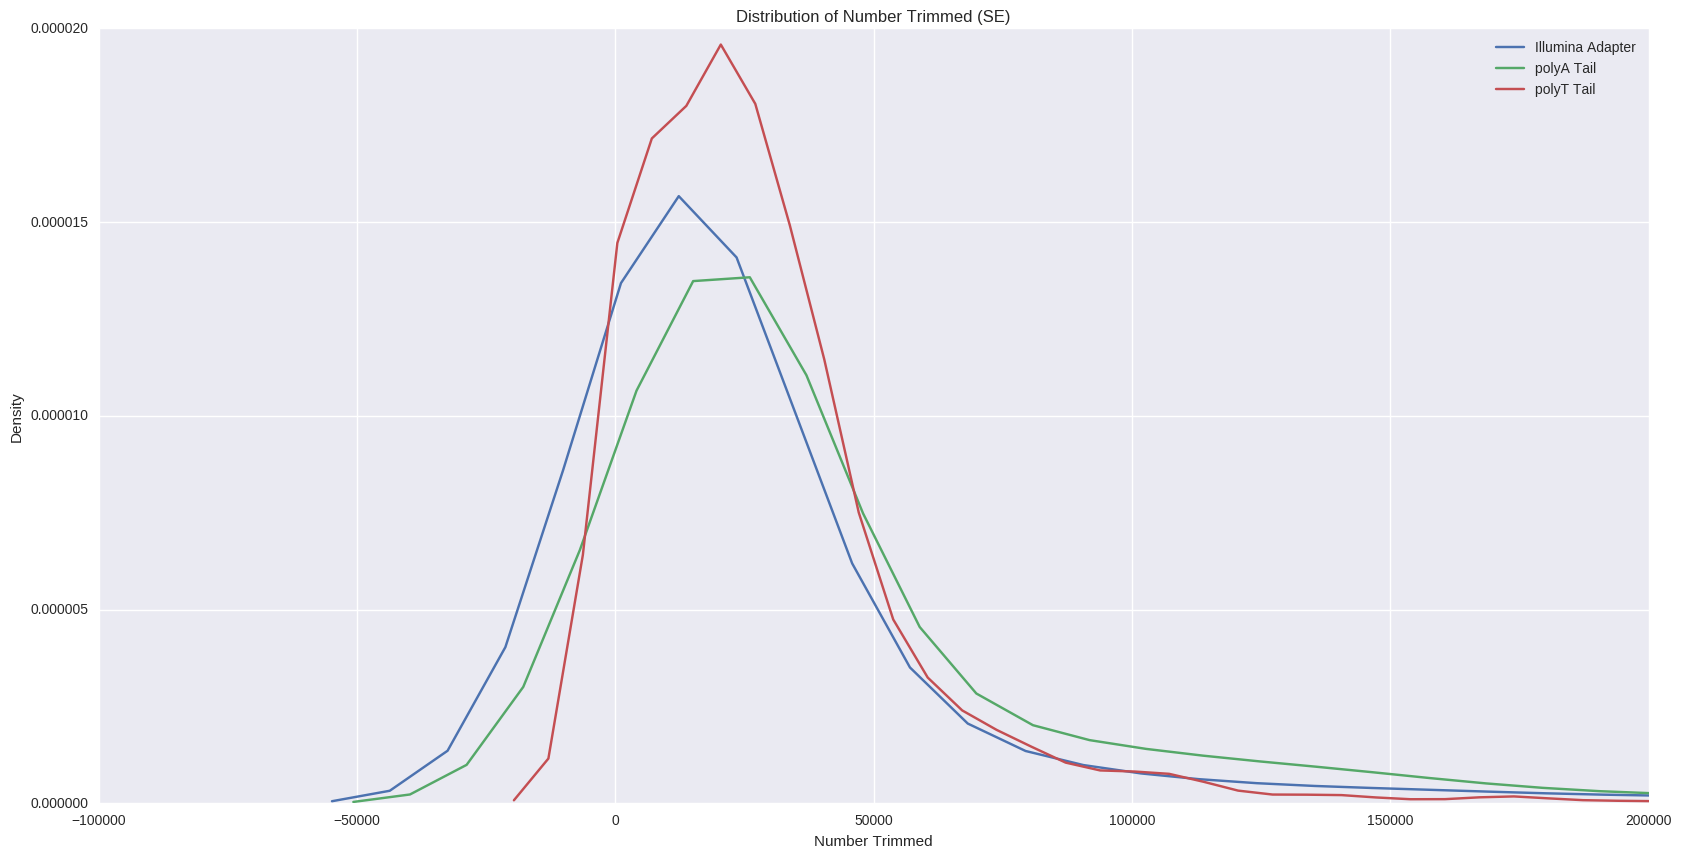

In [52]:
# Plot Density of trimmed (se)
fig = plt.figure(figsize=(20, 10))
sns.distplot(se['Number Adapter illumina trimmed'], hist=False, label='Illumina Adapter')
sns.distplot(se['Number Adapter polyA trimmed'], hist=False, label='polyA Tail')
ax = sns.distplot(se['Number Adapter polyT trimmed'], hist=False, label='polyT Tail')
_ = ax.set_title('Distribution of Number Trimmed (SE)')
_ = ax.set_xlabel('Number Trimmed')
_ = ax.set_ylabel('Density')
_ = ax.set_xlim(-100000, 200000)

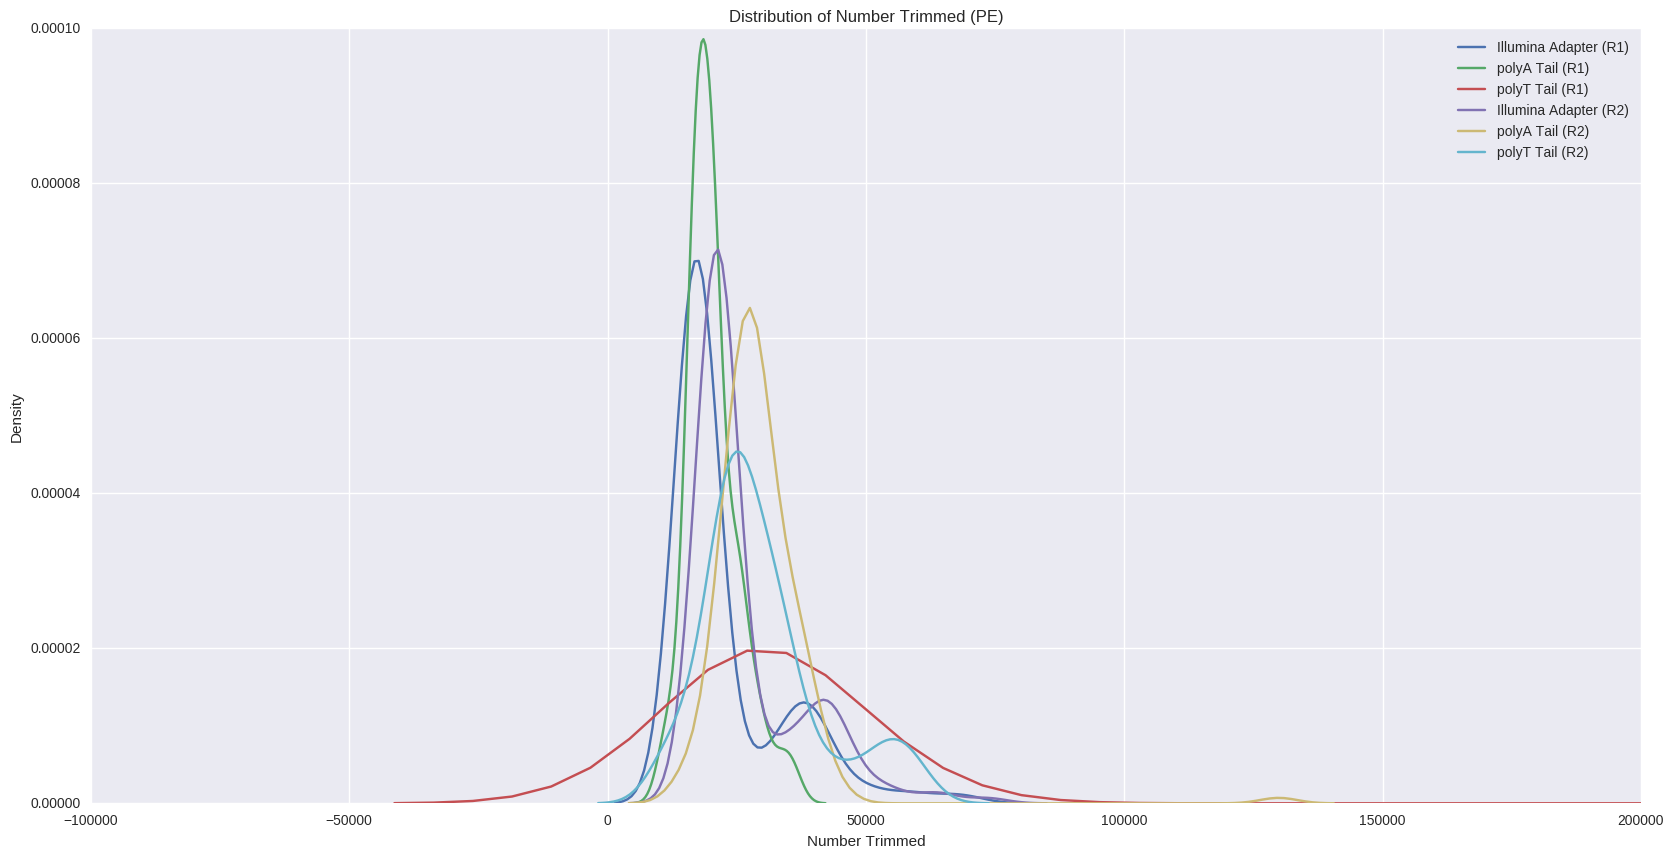

In [40]:
# Plot Density of trimmed (pe)
fig = plt.figure(figsize=(20, 10))
sns.distplot(pe['Number First read: Adapter illumina trimmed'], hist=False, label='Illumina Adapter (R1)')
sns.distplot(pe['Number First read: Adapter polyA trimmed'], hist=False, label='polyA Tail (R1)')
sns.distplot(pe['Number First read: Adapter polyT trimmed'], hist=False, label='polyT Tail (R1)')
sns.distplot(pe['Number Second read: Adapter illumina trimmed'], hist=False, label='Illumina Adapter (R2)')
sns.distplot(pe['Number Second read: Adapter polyA trimmed'], hist=False, label='polyA Tail (R2)')
ax = sns.distplot(pe['Number Second read: Adapter polyT trimmed'], hist=False, label='polyT Tail (R2)')
_ = ax.set_title('Distribution of Number Trimmed (PE)')
_ = ax.set_xlabel('Number Trimmed')
_ = ax.set_ylabel('Density')
_ = ax.set_xlim(-100000, 200000)

# FASTQC

In [170]:
# Import logs and munge
fqc = parse_files(flist, '../../output/prealignment/raw/{experiment}/{sample}/{sample}_fastqc.zip', parse_fastqc_base_quality)

fqc = fqc.unstack()
fqc.columns = fqc.columns.droplevel(0)

# order columns
cols = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16",
"17", "18", "19", "20", "21", "22", "23", "24", "25", "26", "27", "28", "29", "30", "31",
"32", "33", "34", "35", "36", "37", "38", "39", "40", "41", "42", "43", "44", "45", "46",
"47", "48", "49", "50", "51", "52", "53", "54", "55", "56", "57", "58", "59", "60", "61",
"62", "63", "64", "65", "66", "67", "68", "69", "70", "71", "72", "73", "74", "75", "76",
"10-11", "12-13", "14-15", "16-17", "18-19", "20-21", "22-23", "24-25", "26-27", 
"28-29", "30-31", "32-33", "34-35", "36-37", "38-39", "40-41", "42-43", "44-45", "46-47",
"48-49", "50-51", "52-53", "54-55", "56-57", "58-59", "60-61", "62-63", "64-65", "66-67",
"68-69", "70-71", "72-73", "74-75", "76-77", "78-79", "82-83", "84-85", "86-87", "88-89",
"90-91", "92-93", "94-95", "96-97", "98-99", "100-101"]
fqc = fqc[cols]

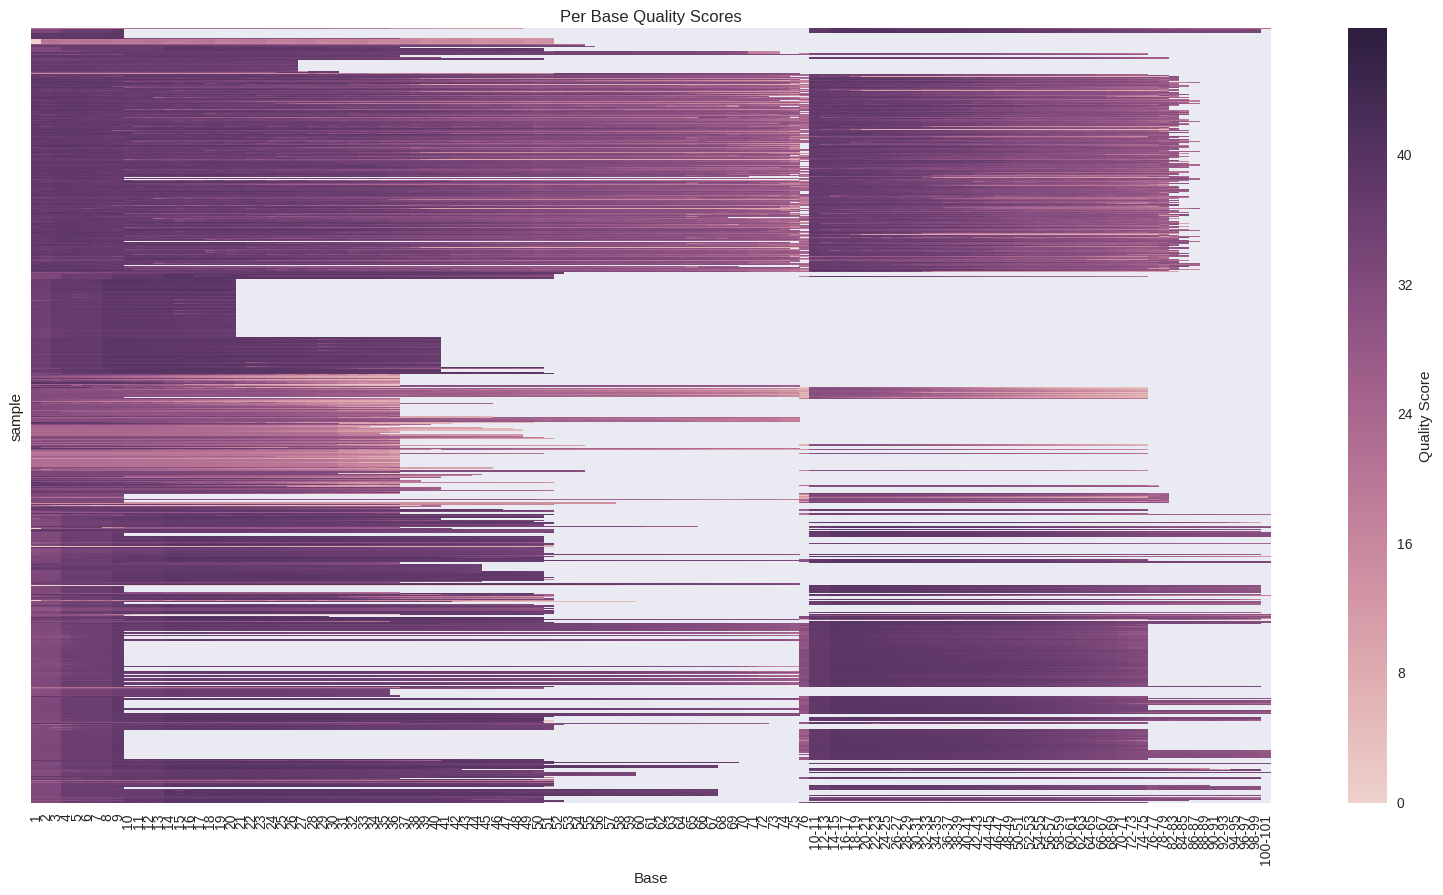

In [172]:
# Plot heatmap of per base quality
fig = plt.figure(figsize=(20, 10))
ax = sns.heatmap(fqc, cmap=sns.cubehelix_palette(as_cmap=True), 
                 yticklabels=False, cbar_kws={'label': 'Quality Score'})
_ = ax.set_title('Per Base Quality Scores')

# Fastq Screen

In [199]:
# Parse fastq screen
fqScreen = parse_files(flist, '../../output/prealignment/raw/{experiment}/{sample}/{sample}_1.clean_screen.txt', parse_fqscreen)

# Munge Counts
cnt = fqScreen.loc[:, (slice(None), ['one_hit_one_library', 'multiple_hits_one_library'], 'count')].copy()
cols = ['dm6',  'rRNA',  'adapters',  'ercc',  'phix',  'wolbachia', 'yeast', 'hg19',  'ecoli']
cnt2 = cnt.groupby(level=0, axis=1).sum()[cols]

# Calculate percent
total = cnt2.sum(axis=1)
cnt2_per = (cnt2.T / total * 100).T

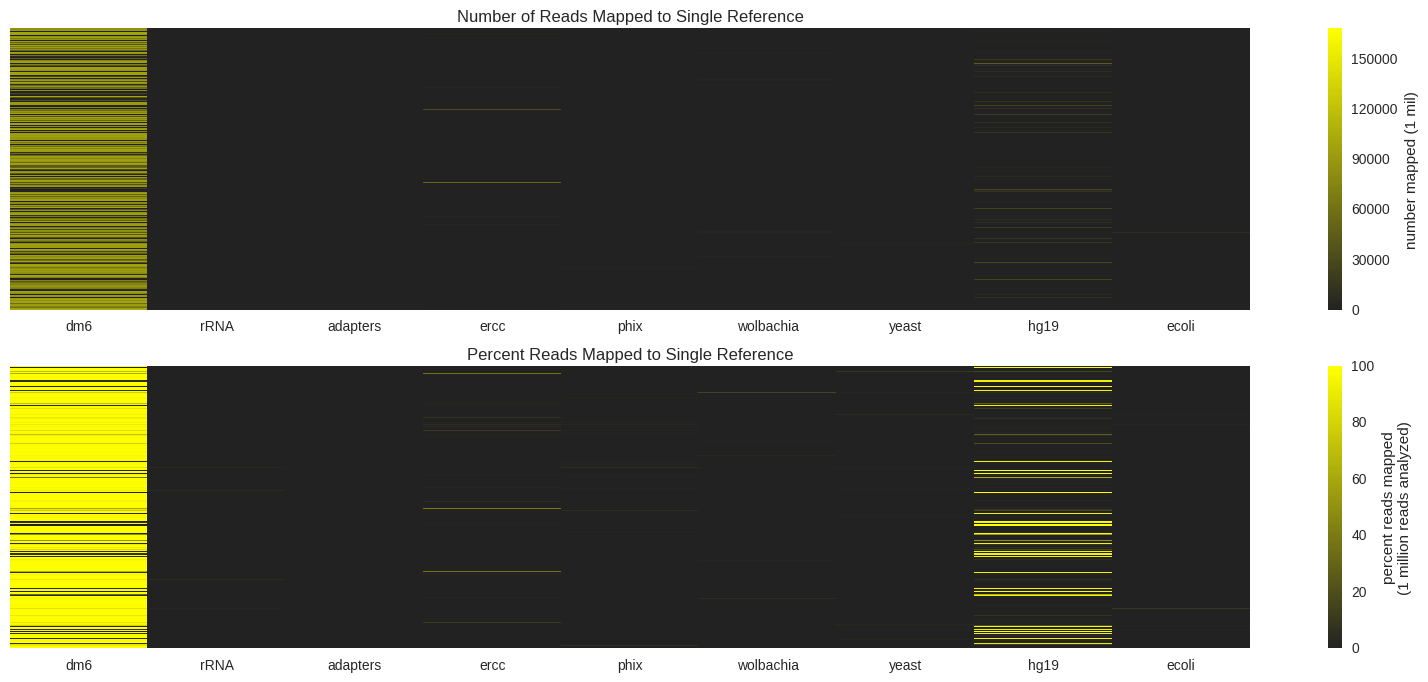

In [6]:
# Plot heatmap
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,8))
sns.heatmap(cnt2, yticklabels=False, cmap=sns.dark_palette('yellow', as_cmap=True), 
            cbar_kws={'label': 'number mapped (1 mil)'}, ax=ax1)

sns.heatmap(cnt2_per.dropna(), yticklabels=False, cmap=sns.dark_palette('yellow', as_cmap=True), 
                cbar_kws={'label': 'percent reads mapped\n(1 million reads analyzed)'}, ax=ax2)

ax1.set_title('Number of Reads Mapped to Single Reference')
_ = ax2.set_title('Percent Reads Mapped to Single Reference')

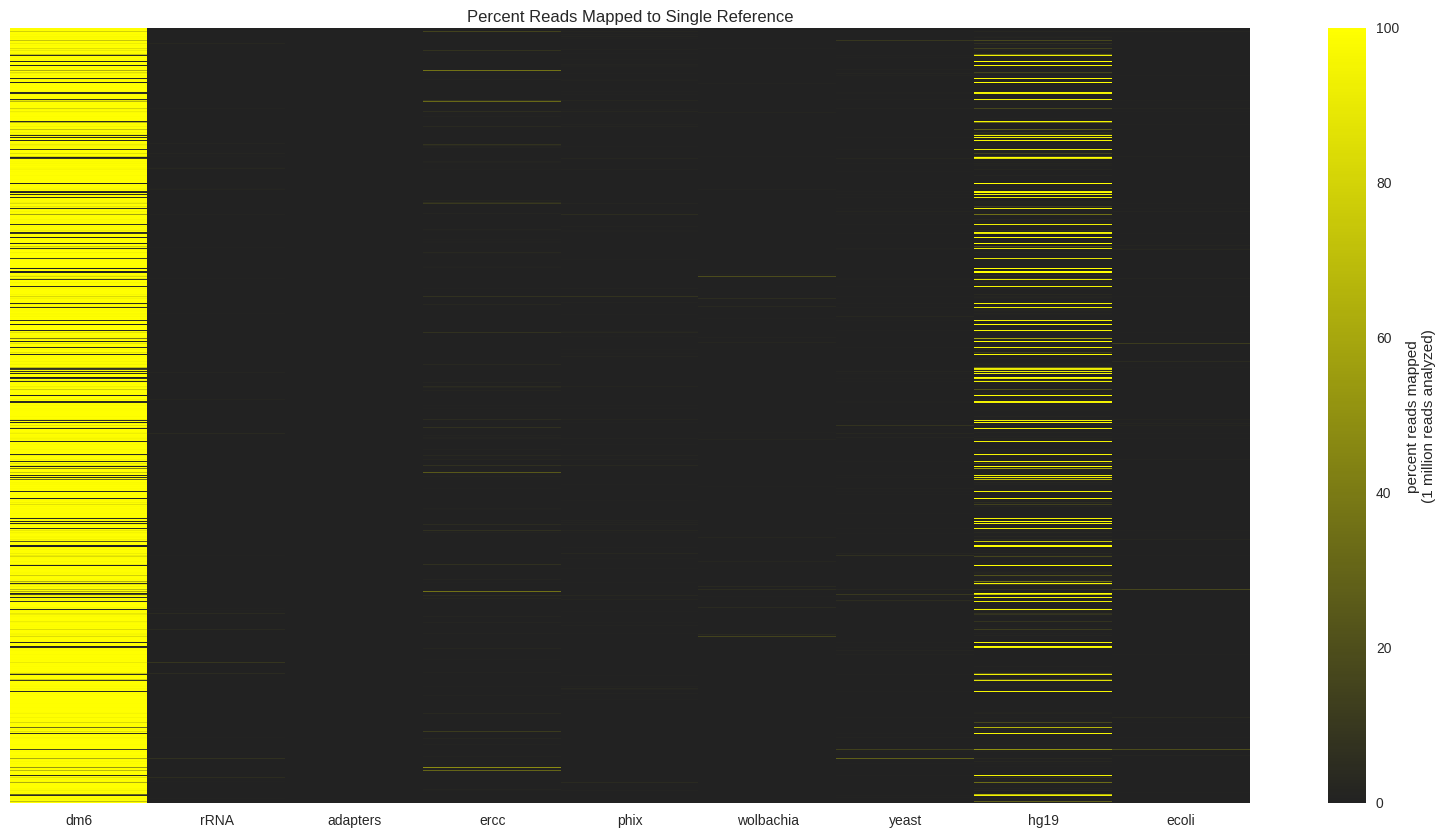

In [202]:
# Plot heatmap
fig = plt.figure(figsize=(20, 10))
ax = sns.heatmap(cnt2_per.dropna(), yticklabels=False, cmap=sns.dark_palette('yellow', as_cmap=True), 
                cbar_kws={'label': 'percent reads mapped\n(1 million reads analyzed)'})

_ = ax.set_title('Percent Reads Mapped to Single Reference')

# Picard Gene Body Coverage

In [173]:
# Parse picard gene body coverage histogram
picard2 = parse_files(flist, '../../output/prealignment/raw/{experiment}/{sample}/{sample}_FIRST_READ_TRANSCRIPTION_STRAND.fq.bam.picard.collectrnaseqmetrics', parse_picardCollect_hist)

In [174]:
# Construct Clusters
row_linkage = linkage(picard2, 'average')
c, _ = cophenet(row_linkage, pdist(picard2))
print('The cophenet score is: {}'.format(c))

clusters = fcluster(row_linkage, 700, 'maxclust')
clustDf= pd.DataFrame(clusters, index=picard2.index, columns=['cluster'])
pal = sns.cubehelix_palette(n_colors=700, start=0, rot=1, hue=1, gamma=0.4, light=1, dark=0)
mapper = {k: v for k, v in zip(range(1, 701), pal)}
colors = clustDf['cluster'].map(lambda x: mapper[x])

The cophenet score is: 0.9867486054526238


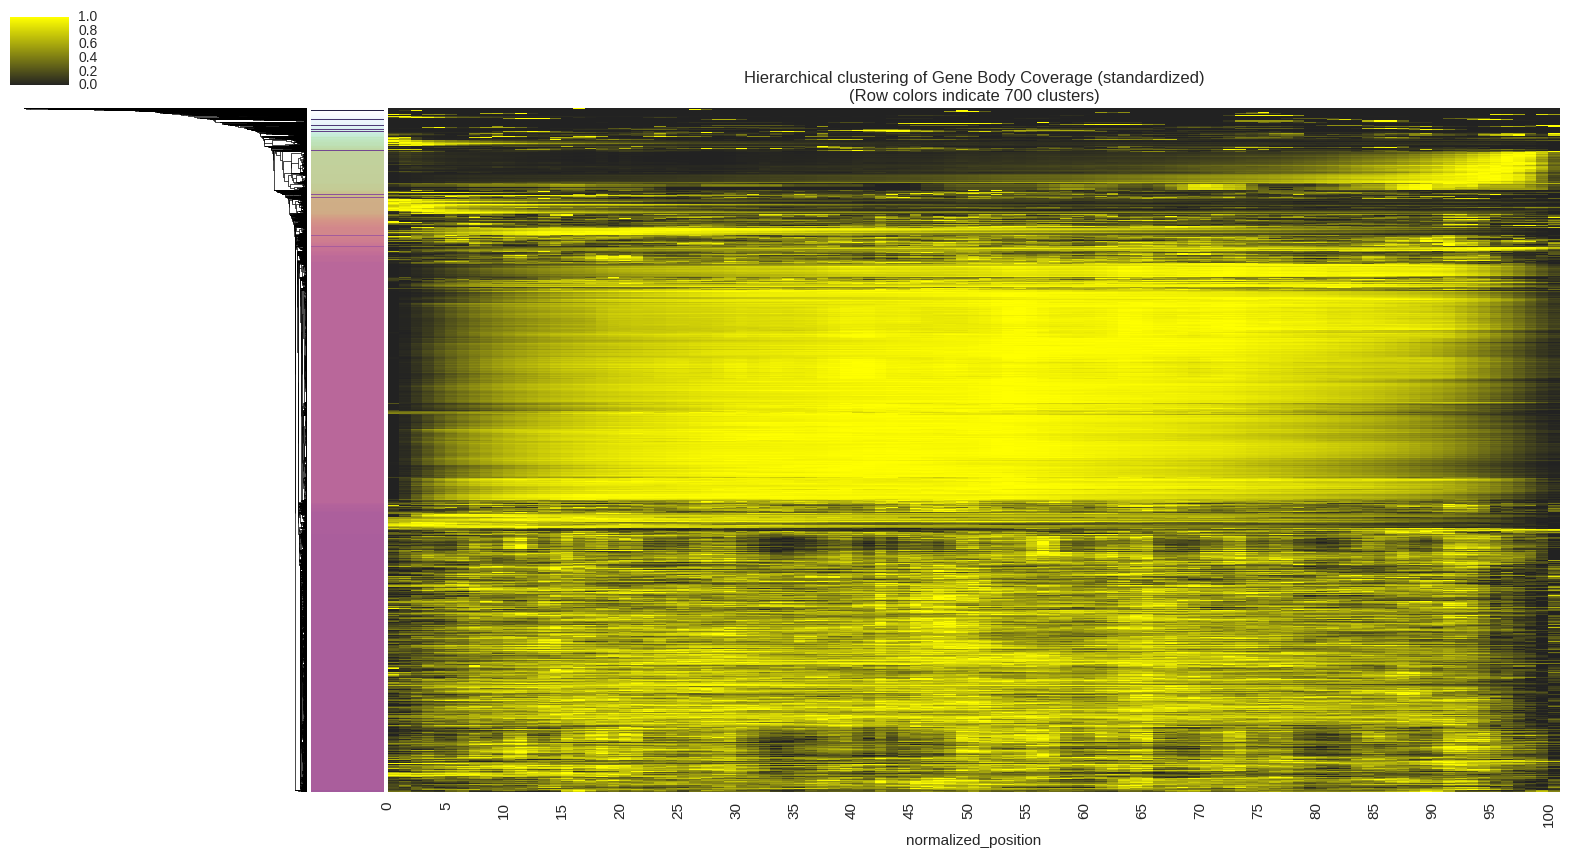

In [178]:
# Draw Heatmap
clust = sns.clustermap(picard2, 
               row_linkage=row_linkage, 
               col_cluster=False, 
               yticklabels=False,
               standard_scale=0,
               cmap=sns.dark_palette('yellow', as_cmap=True),
               row_colors=colors,
               figsize=(20, 10)
              )
_ = clust.ax_heatmap.set_title('Hierarchical clustering of Gene Body Coverage (standardized)\n(Row colors indicate 700 clusters)')
_ = clust.ax_heatmap.xaxis.set_ticks(range(0, 101, 5))
_ = clust.ax_heatmap.xaxis.set_ticklabels(range(0, 101, 5), fontsize=11)
_ = clust.ax_row_colors.xaxis.set_visible(False)

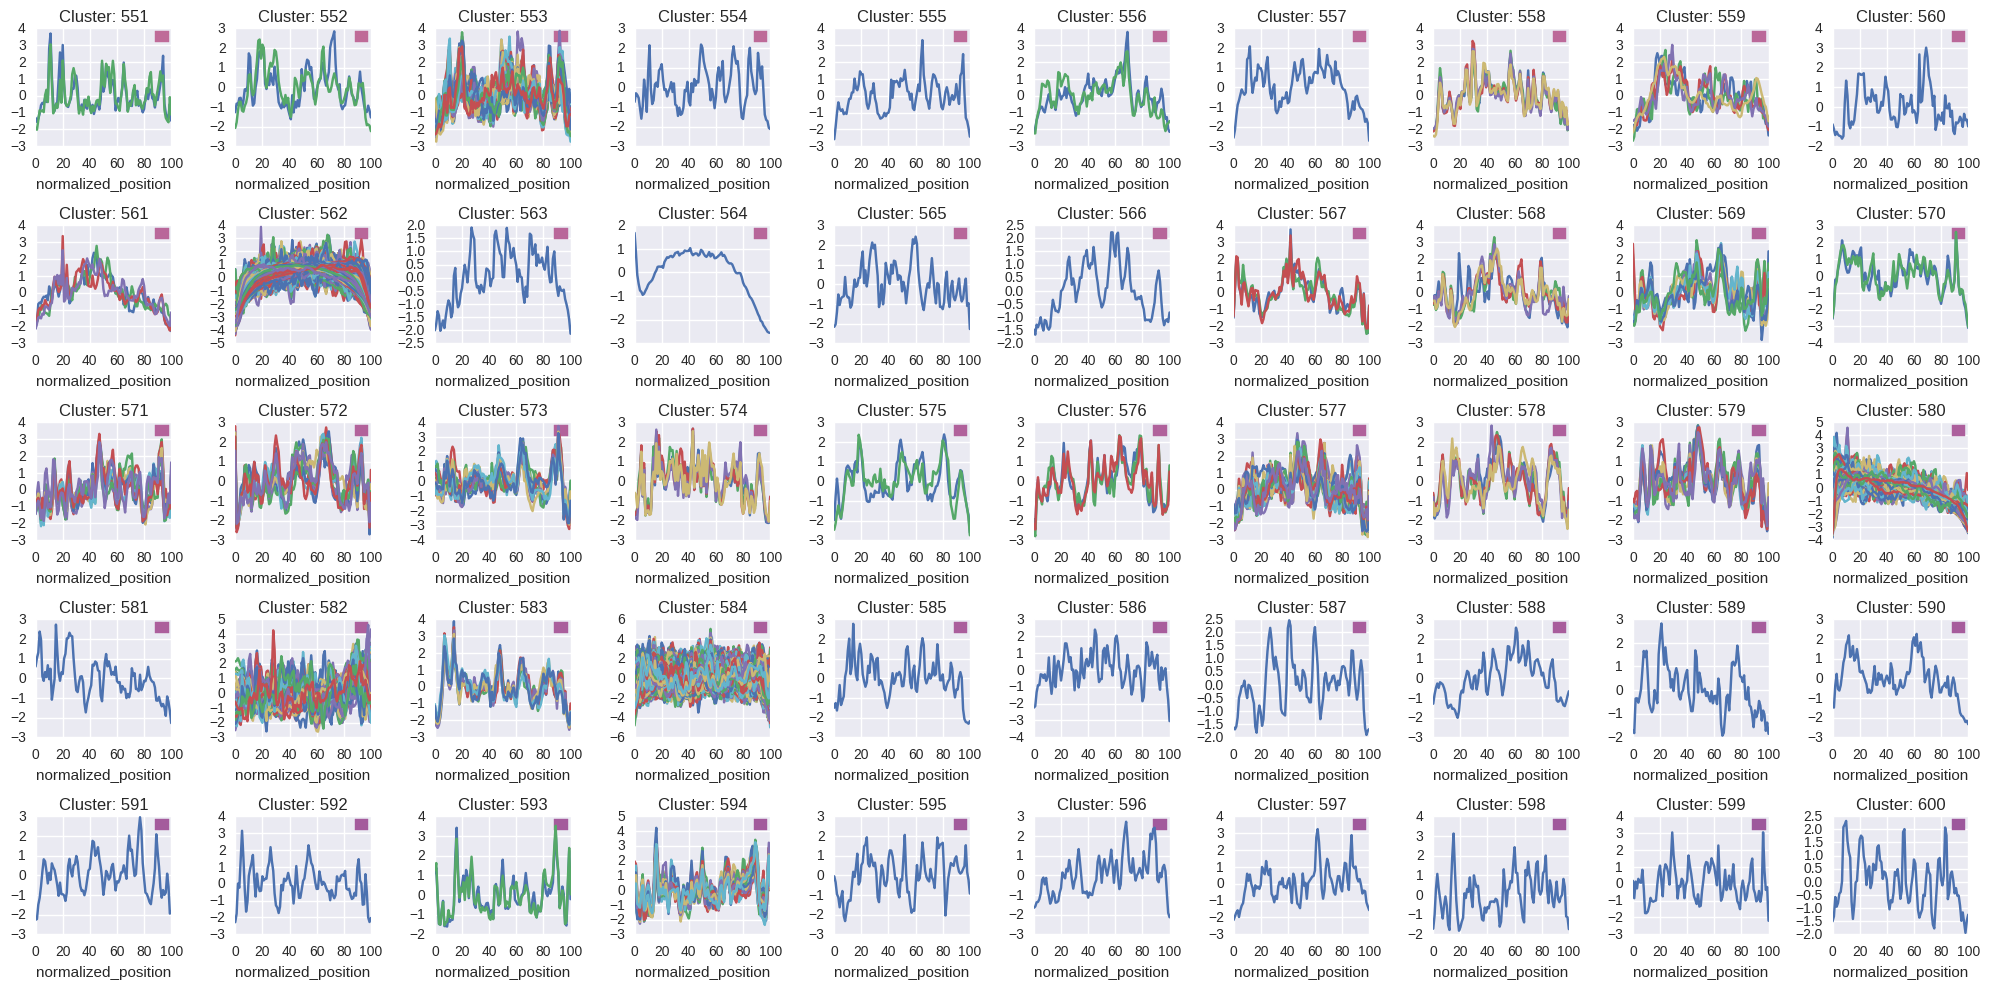

In [184]:
# Plot density graphs of coverage by cluster
norm = picard2.apply(lambda x: (x - x.mean()) / x.std(), axis=1)
fig, axes = plt.subplots(5, 10, figsize=(20, 10))
axes = np.ravel(axes)
for g, d in clustDf.reset_index().groupby('cluster'):
    if 550 < g < 601:
        ax = axes[g-551]
        ax.add_patch(plt.Rectangle((.88,.88), .1, .1, color=mapper[g], transform=ax.transAxes))
        norm.loc[d['index']].T.plot(legend=False, ax=ax, title='Cluster: {}'.format(g))
plt.tight_layout()

In [185]:
deviation = picard2.iloc[:, range(20, 81)].std(axis=1)

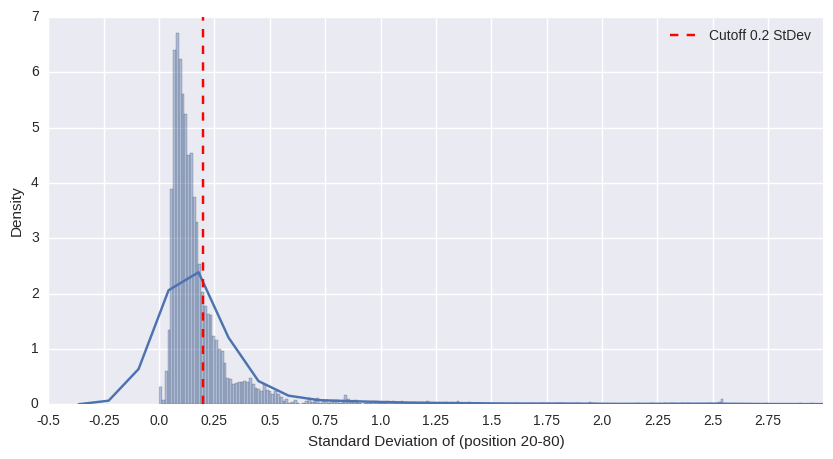

In [194]:
fig = plt.figure(figsize=(10, 5))
ax = sns.distplot(deviation, bins=1000)
_ = ax.xaxis.set_ticks(np.arange(-0.5, 3, 0.25))
_ = ax.xaxis.set_ticklabels(np.arange(-0.5, 3, 0.25))
_ = ax.axvline(0.2, ls='--', color='r', label='Cutoff 0.2 StDev')
_ = ax.set_xlabel('Standard Deviation of (position 20-80)')
_ = ax.set_ylabel('Density')
_ = ax.set_xlim(-0.5, 3)
plt.legend()

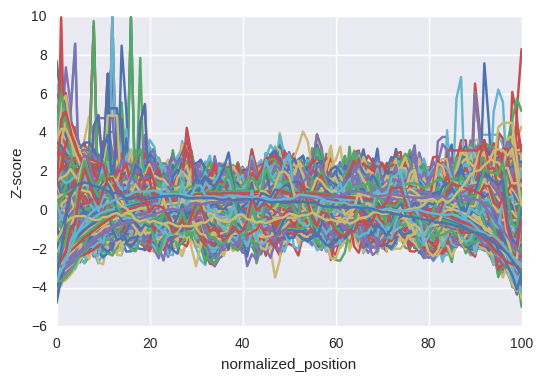

In [195]:
fig = plt.figure(figsize=(10, 5))
ax = norm[deviation <= .2].T.plot(legend=False)
ax.set_ylabel('Z-score')

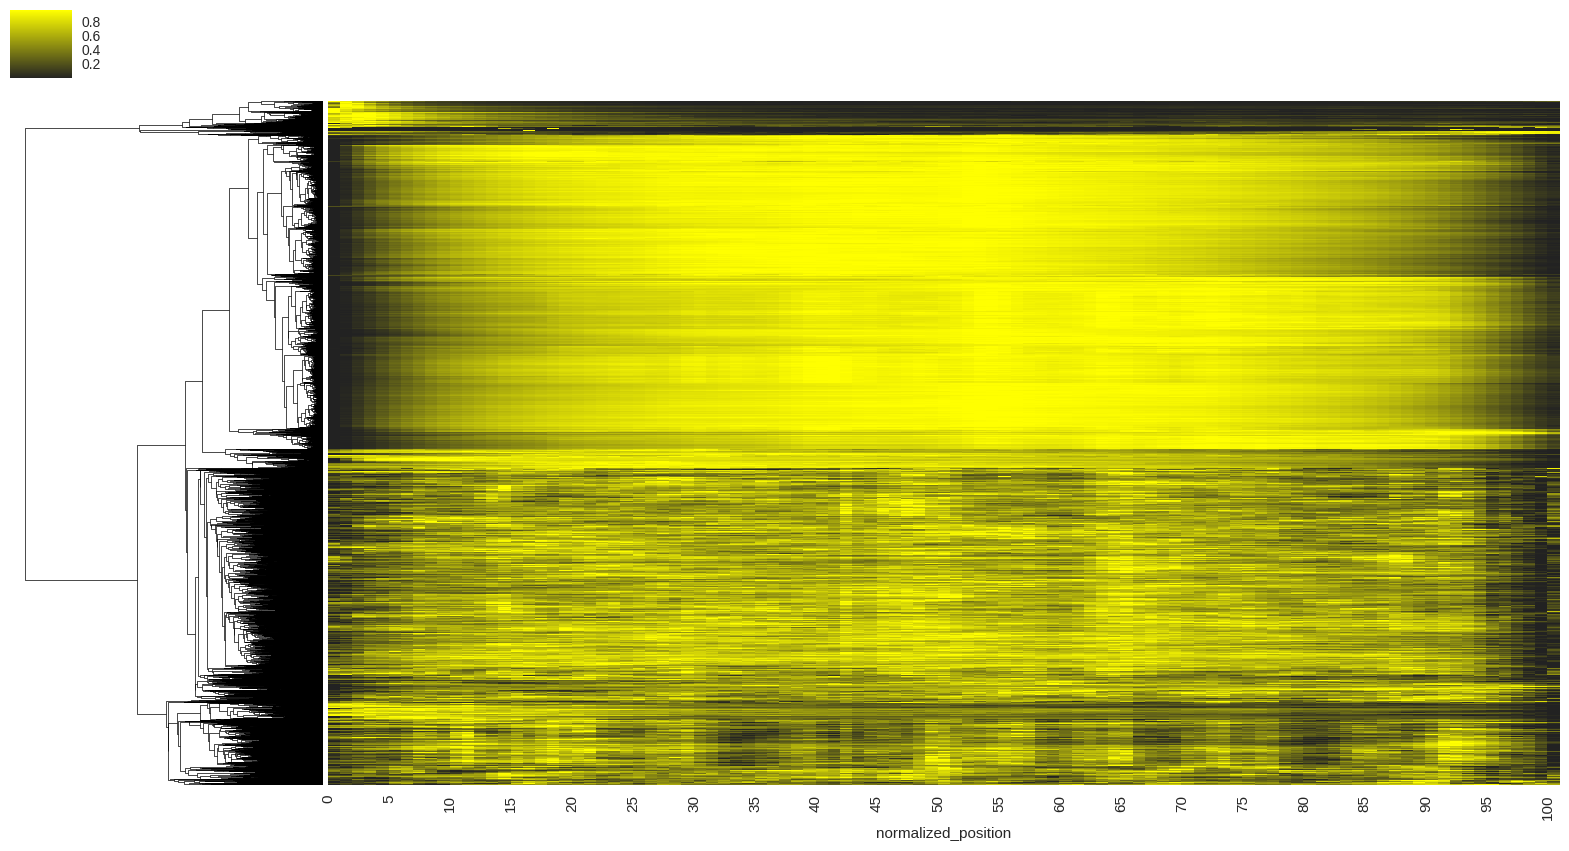

In [197]:
# Draw Heatmap
sns.set(font_scale=1)
clust = sns.clustermap(picard2[deviation < .2],
               col_cluster=False, 
               yticklabels=False,
               standard_scale=0,
               robust=True,
               cmap=sns.dark_palette('yellow', as_cmap=True),
               figsize=(20, 10)
              )
#clust.ax_heatmap.set_title('Hierarchical clustering of Gene Body Coverage (standardized)\n(Row colors indicate 20 clusters)')
_ = clust.ax_heatmap.xaxis.set_ticks(range(0, 101, 5))
_ = clust.ax_heatmap.xaxis.set_ticklabels(range(0, 101, 5), fontsize=11)

# Feature Counts

In [4]:
#featureCounts = parse_files(flist[:100], '../../output/prealignment/raw/{experiment}/{sample}/{sample}_1.fq.bam.counts', parse_featureCounts_counts)
featureCounts_summary = parse_files(flist, '../../output/prealignment/raw/{experiment}/{sample}/{sample}_1.fq.bam.counts.summary', parse_featureCounts_summary)

In [5]:
featureCounts_summary.head()

,Assigned,Unassigned_Ambiguity,Unassigned_MultiMapping,Unassigned_NoFeatures,Unassigned_Unmapped,Unassigned_MappingQuality,Unassigned_FragmentLength,Unassigned_Chimera,Unassigned_Secondary,Unassigned_Nonjunction,Unassigned_Duplicate
SRR1505834,385968,5646,29233,387520,210894,0,0,0,0,0,0
SRR031749,386033,5634,62656,327886,262278,0,0,0,0,0,0
SRR031748,435662,6150,76429,371870,164447,0,0,0,0,0,0
SRR1543709,3089,89,2730323,136284,176856,0,0,0,0,0,0
ERR650000,819,11,455,3700,383988,0,0,0,0,0,0


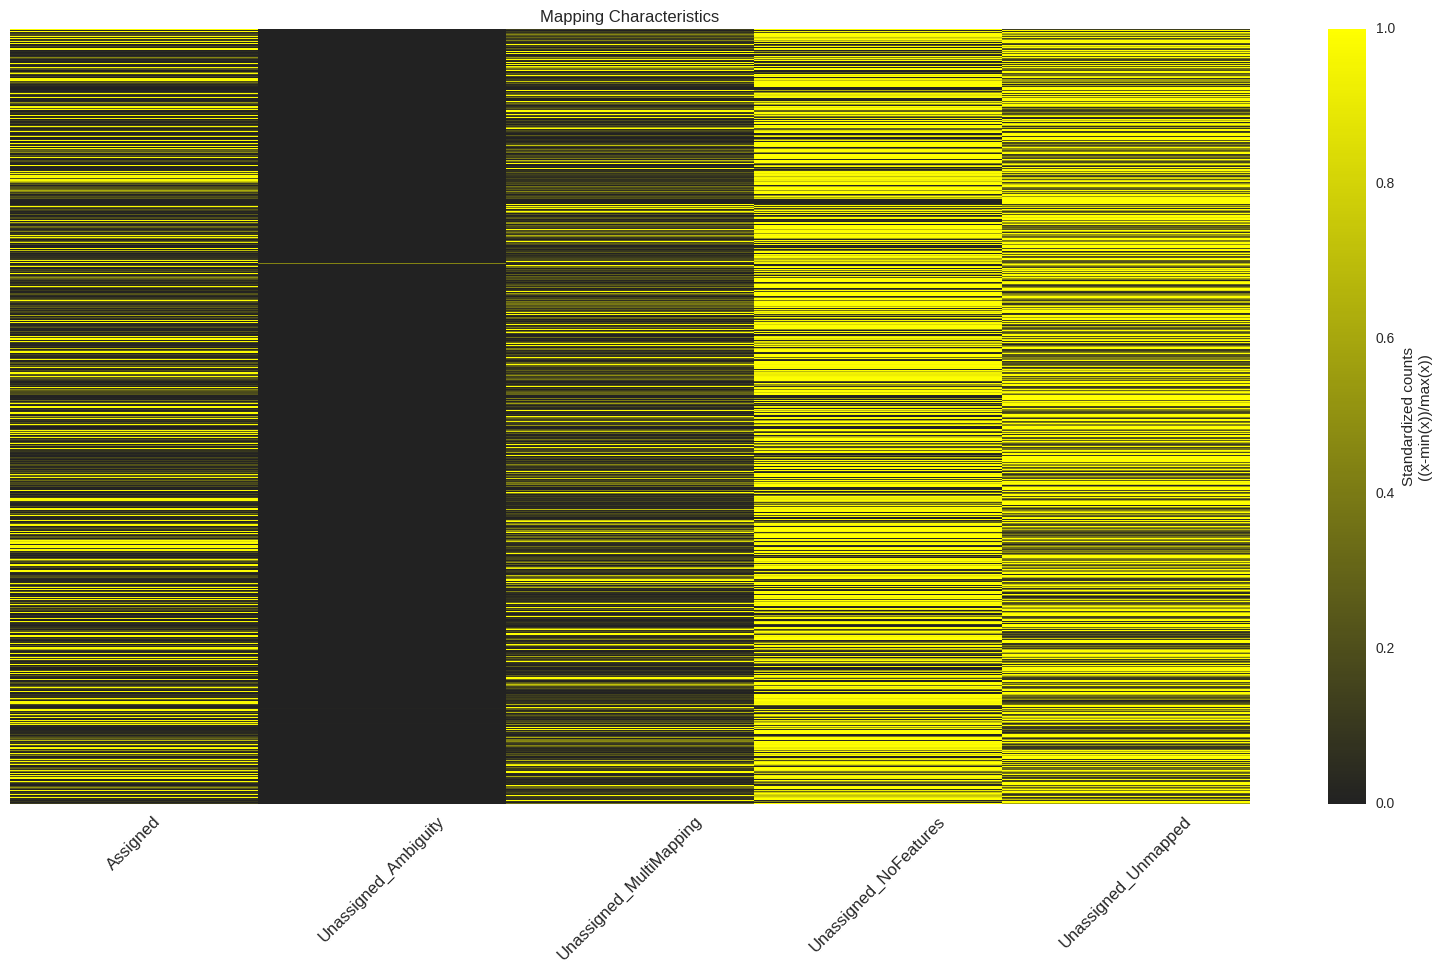

In [25]:
clean = featureCounts_summary.drop(featureCounts_summary.columns[(featureCounts_summary == 0).all(axis=0)], axis=1).copy()
standard = clean.apply(lambda x: (x - x.min()) / x.max(), axis=1)

fig = plt.figure(figsize=(20, 10))
ax = sns.heatmap(standard, cmap=sns.dark_palette('yellow', as_cmap=True), yticklabels=False, cbar_kws={'label': 'Standardized counts\n((x-min(x))/max(x))'})
_ = ax.set_title('Mapping Characteristics')
l = ax.xaxis.get_ticklabels()
_ = ax.xaxis.set_ticklabels(l, fontsize=12, rotation=45)